### Import libraries and data

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
# pip install geopandas
import geopandas as gpd
from shapely.geometry import Polygon
import os
from shapely.geometry import Polygon, MultiPolygon, MultiPoint
import pyproj
from shapely.ops import transform
from functools import partial


parent_directory = os.path.dirname(os.getcwd())
bike_file_path = parent_directory + '/data/Existing_Bike_Network_2023.geojson'

bike_lanes = gpd.read_file(bike_file_path)
bike_lanes['year'] = pd.to_numeric(bike_lanes['InstallDat'], errors = 'coerce').astype('Int64')

blocks_file_path = parent_directory + '/data/census2020_blockgroups.json'
blocks = gpd.read_file(blocks_file_path)

#### format polygons + group into tracts

In [52]:
# convert block polygons to Lat-Long 


# Define the UTM projection for Zone 19T (for Boston, MA)
state_plane = pyproj.Proj(init='epsg:2249', preserve_units=True)

# Define a function to convert UTM coordinates to latitude and longitude
def utm_to_latlon(x, y):
    lon, lat = state_plane(x, y, inverse=True)
    return lon, lat

# Define a function to transform coordinates to UTM and then to latitude and longitude
def transform_to_latlon(geom):
    transformed_geom = transform(partial(pyproj.transform, state_plane, pyproj.Proj(init='epsg:4326')), geom)
    return transformed_geom

for i, row in blocks.iterrows():
    poly = row['geometry']
    # Check if the geometry is a MultiPolygon
    if poly.geom_type == 'MultiPolygon':
        # If it's a MultiPolygon, iterate through individual polygons
        polygon_latlon = []
        for single_poly in poly.geoms:
            for ring in single_poly.exterior.coords:
                lat, lon = utm_to_latlon(ring[0], ring[1])
                polygon_latlon.append((lat, lon))
        formatted_polygon = MultiPolygon([Polygon(polygon_latlon)])
    else:
        polygon_latlon = []
        for ring in poly.exterior.coords:
            lat, lon = utm_to_latlon(ring[0], ring[1])
            polygon_latlon.append((lat, lon))
        formatted_polygon = Polygon(polygon_latlon)
    
    blocks.at[i, 'formatted_polygon'] = formatted_polygon

c:\Users\Raviv\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


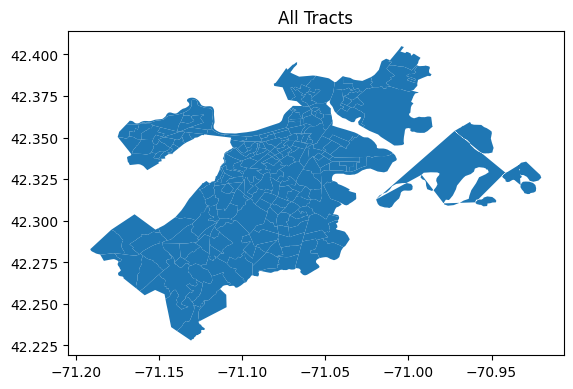

In [105]:
from shapely.ops import unary_union
grouped_tracts = blocks.groupby('TRACTCE20')['formatted_polygon'].apply(unary_union).reset_index()
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='formatted_polygon')

# Plot the polygons
tracts_gdf.plot()
plt.title('All Tracts')
plt.show()

In [212]:
# define circle for each tract: centroid point + defined radius
import math
RADIUS = 0.5 # in km

def km_to_degrees(km, latitude):
    # Radius of the Earth in meters
    earth_radius = 6378137.0

    # Calculate the circumference of the Earth at given latitude
    circumference = 2 * math.pi * earth_radius * math.cos(math.radians(latitude))

    # Convert meters to degrees of longitude
    degrees_per_meter = 360.0 / circumference
    degrees = km *1000 * degrees_per_meter

    return degrees

for i, row in grouped_tracts.iterrows():
    # Find the center point (centroid) of the combined polygon
    center_point = row['formatted_polygon'].centroid
    lat = center_point.y
    # Define radius of the circle
    radius_km = RADIUS  # Change this value to set the radius of the circle
    radius_deg = km_to_degrees(radius_km, lat)
    # Create a circle around the center point with the specified radius
    circle = Point(center_point).buffer(radius_deg)
    grouped_tracts.at[i, 'circle'] = circle

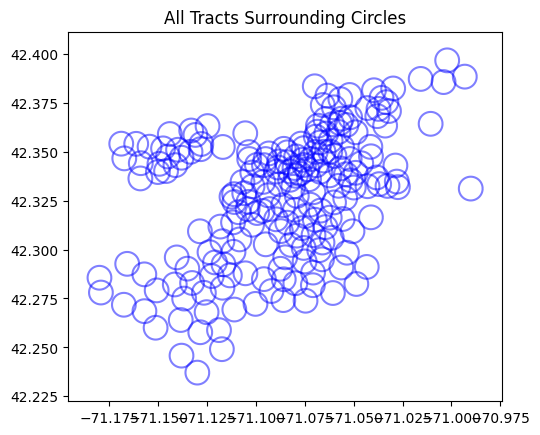

In [213]:
tracts_gdf = gpd.GeoDataFrame(grouped_tracts, geometry='circle')

# Plot the polygons
tracts_gdf.plot(facecolor='none', edgecolor='blue', linewidth=1.5, alpha=0.5)
plt.title('All Tracts Surrounding Circles')
plt.show()

In [ ]:
#define bike lane dictionary
infra_dict = {'BFBL' : 'Buffered bike lane',
'BL' : 'Bike lane',
'BLSL' : 'Bike lane on one side, shared lane on the opposite side',
'BSBL' : 'Bus/bike lane',
'CFBL' : 'Contra-flow bike street',
'NSUP' : 'Shared use path, natural surface',
'NW' : 'Neighborway, marked',
'NW-U' : 'Neighborway, unmarked',
'SBL' : 'Separated bike lane',
'SBLBL' : 'Separated bike lane on one side, bike lane on the opposite side',
'SLM' : 'Shared lane markings',
'SLMTC' : 'Shared lane markings, Traffic calmed street',
'SRd' : 'Shared road',
'SUB' : 'Shared use path bridge',
'SUC' : 'Shared use connector',
'SUP' : 'Shared use path',
'TC' : 'Traffic calmed street',
}
bike_lanes['ExisFacil'].replace(infra_dict, inplace=True) # remove later

##### Dorchester

In [223]:
# Define the coordinates of the polygon (clockwise or counterclockwise order)
# Repeat the first point to close the polygon
# coords are written (long, lat), reversed from map data 
dorchester = [(-71.09631340189638, 42.29181136750529), ( -71.06352608002106, 42.33065605689039), ( -71.03297035596972, 42.3165681070428),
                   ( -71.05391304324087,42.30768219241062), ( -71.03760521298875, 42.28838274399551), (-71.07176582583267, 42.27834977370352),
                    ( -71.09631340189638, 42.29181136750529) ] 

# Create a Polygon object from the coordinates
dorchester_poly = Polygon(dorchester)
dorchester_bike = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]
dorchester_bike = bike_lanes[bike_lanes.geometry.within(dorchester_poly)]




Text(0.5, 1.0, 'tracts + surrounding areas - Dorchester')

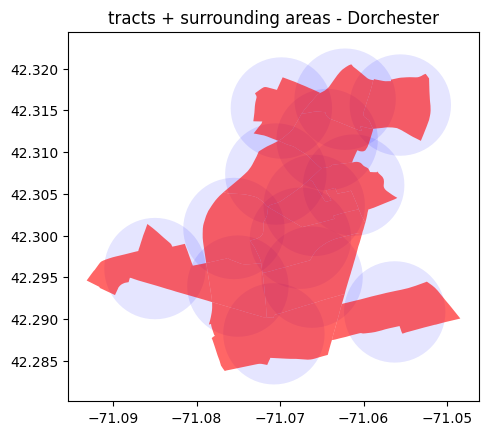

In [224]:

dorchester_tracts = grouped_tracts[grouped_tracts['formatted_polygon'].apply(lambda polygon: polygon.within(dorchester_poly))]

# Create a new figure and axis
fig, ax = plt.subplots()
dorch_circle = gpd.GeoDataFrame(dorchester_tracts, geometry='circle')
dorch_circle['circle'].plot(color='b', ax=ax, linestyle='dashed', facecolor='none', linewidth=1.5, alpha=0.1)
dorch_poly = gpd.GeoDataFrame(dorchester_tracts, geometry='formatted_polygon')
# Plot the 'circle' column in red with a different linestyle
dorch_poly['formatted_polygon'].plot(ax=ax ,color='r', linestyle='dashed', facecolor='none', linewidth=1.5, alpha=0.6)
plt.title('tracts + surrounding areas - Dorchester')

In [225]:
dorchester_gdf.head(1)

,FID,STREET_NAM,ROADINVENT,FUNCTIONAL,JURISDICTI,Divided,InstallDat,ExisFacil,Shape_Leng,Shape__Length,geometry,year
136,137,Blue Hill Avenue,6212400,3,2,1,2010,BL,74.936117,74.936117,"LINESTRING (-71.08949 42.29045, -71.08971 42.2...",2010


In [8]:
# Streets with most bike lanes
street_df = dorchester_gdf.loc[dorchester_gdf['STREET_NAM']!=' ']
total_length_df = street_df.groupby(['STREET_NAM'])['Shape_Leng'].sum().reset_index()
total_length_df.rename(columns={'Shape_Leng': 'Total_Length'}, inplace=True)
total_length_df.sort_values(by='Total_Length',ascending=False,inplace=True)
top_5_streets = total_length_df.head(5)
top_5_streets.STREET_NAM.to_list()

['Columbia Road',
 'Dorchester Avenue',
 'Blue Hill Avenue',
 'Talbot Avenue',
 'American Legion Highway']

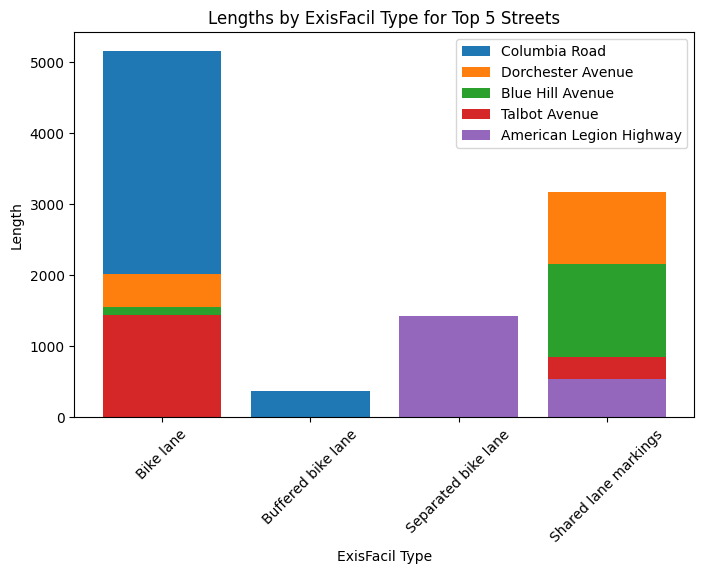

In [9]:
# length by street, for each facility type

data_dict = {}

for street in top_5_streets['STREET_NAM']:
    street_data = street_df.loc[street_df['STREET_NAM'] == street]
    lengths_by_type = street_data.groupby('ExisFacil')['Shape_Leng'].sum().reset_index()
    data_dict[street] = dict(zip(lengths_by_type['ExisFacil'], lengths_by_type['Shape_Leng']))

# Create a single plot with each street on the x-axis and different facility types as bars
plt.figure(figsize=(8, 5))
for street, data in data_dict.items():
    plt.bar(data.keys(), data.values(), label=street)

plt.xlabel('ExisFacil Type')
plt.ylabel('Length')
plt.title('Lengths by ExisFacil Type for Top 5 Streets')
plt.xticks(rotation=45)
plt.legend()
plt.show()


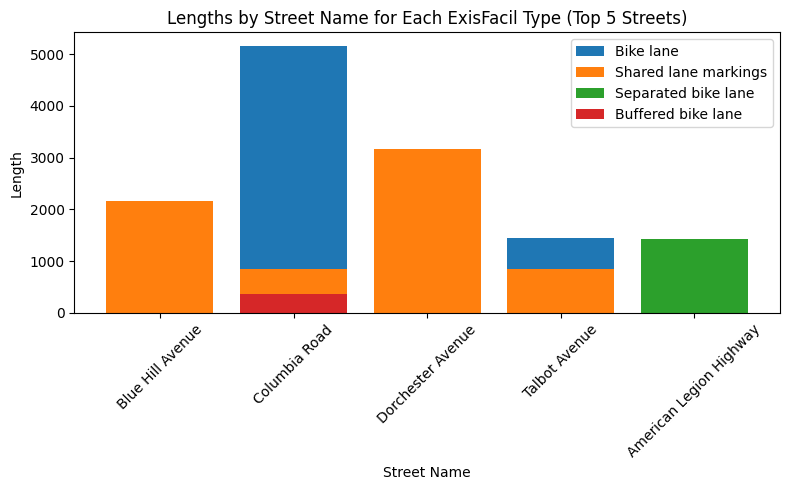

In [10]:
# length by facility type, for each street
data_dict = {}
color_dict = {}
# Populate the dictionary with lengths by Street name for each facility type for the top 5 streets
for facility_type in street_df['ExisFacil'].unique():
    facility_data = street_df.loc[(street_df['ExisFacil'] == facility_type) & (street_df['STREET_NAM'].isin(top_5_streets['STREET_NAM'].tolist()))]
    lengths_by_street = facility_data.groupby('STREET_NAM')['Shape_Leng'].sum().reset_index()
    data_dict[facility_type] = dict(zip(lengths_by_street['STREET_NAM'], lengths_by_street['Shape_Leng']))

unique_facility_types = data_dict.keys()
plt.figure(figsize=(8, 5))
for facility_type, data in data_dict.items():
    # color = color_dict[facility_type]  # Get color for the current facility type
    if data:
        plt.bar(data.keys(), data.values(), label=facility_type)

plt.xlabel('Street Name')
plt.ylabel('Length')
plt.title('Lengths by Street Name for Each ExisFacil Type (Top 5 Streets)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

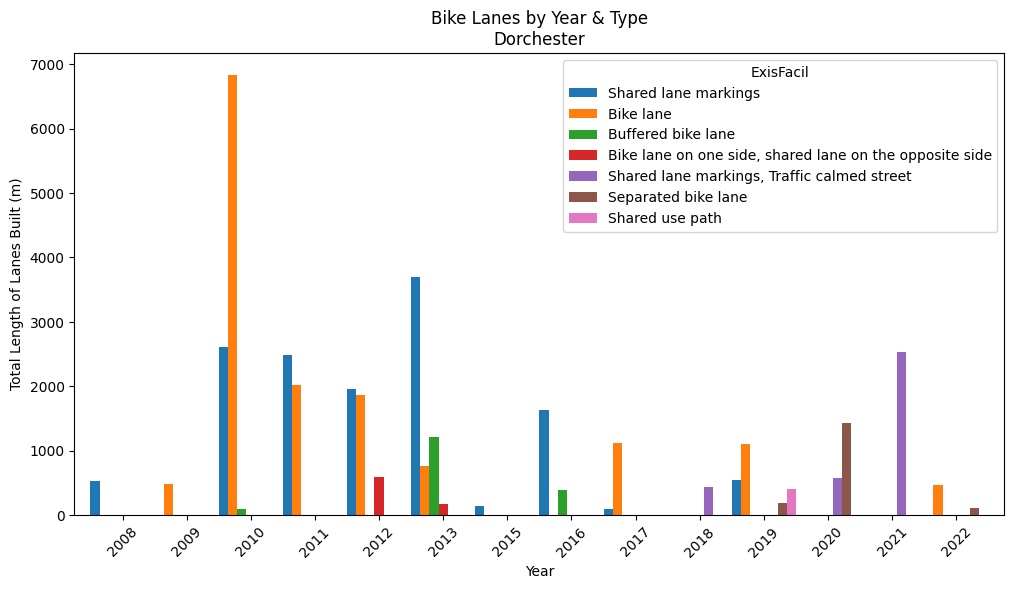

In [11]:
# total m of lanes by year and type
yealy_new_lanes = dorchester_gdf.groupby(['year', 'ExisFacil'])['Shape_Leng'].sum().unstack()
fig, ax = plt.subplots(figsize=(12, 6))
yealy_new_lanes.plot(kind='bar', ax=ax, align='center', width=1)
ax.set_xlabel('Year')
ax.set_ylabel('Total Length of Lanes Built (m)')
ax.set_title('Bike Lanes by Year & Type\nDorchester')
ax.tick_params(axis='x', rotation=45)
plt.show()